In [1]:
#@title Google colab setup

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# For linear algebra
import pandas as pd
import numpy as np

# For plotting and diverse visualizations
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
#@title Functions for dose-response profiling the mercury biosensor

def view(data, y=None, inducer=None):

    """
    Parameters:
    - data: DataFrame containing the optical density, growth rate, fluorescen and production rate data.
    - y: The y-axis parameter to plot (e.g., 'od', 'flu', 'growth_rate', 'production_rate').
    - inducer: If specified, filter data to include only this inducer.
               If None, data for each inducer are plotted.

    Returns:
    - matplotlib figure and axis objects for the plot.
    """

    # Dictionary to map valid y-axis labels to corresponding units
    valid_y_labels = {
        'od': 'OD (a.u)',
        'flu': 'FU (a.u)',
        'growth_rate': 'µ (h⁻¹)',
        'phi': 'Φ (FU) (OD⁻¹)',
        'production_rate': 'ρ (h⁻¹) (OD⁻¹)'
    }

    # Confirm if the "y" input is a valid parameter
    if y not in valid_y_labels:
        raise ValueError(f"{y} is not a valid parameter")

    # Create a copy of the data for plotting
    data = data.copy()

    # Ensure 'inducer' is treated as a categorical variable
    data['inducer'] = data['inducer'].astype('category')

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    if inducer is None:
        # Average data across replicates for each inducer
        avg_data = data.groupby(['inducer', 'time'], observed=False)[y].mean().reset_index()
        avg_data['inducer'] = avg_data['inducer'].astype('category')

        # Plot individual measurements as scatter points
        sns.scatterplot(data=avg_data, x='time', y=y, hue='inducer', palette='inferno_r', alpha=1.0, ax=ax)

        # Plot averaged lines
        sns.lineplot(data=avg_data, x='time', y=y, hue='inducer', palette='inferno_r', ax=ax, legend=False)

    else:
        # Filter by the specified inducer
        filtered_data = data[data['inducer'] == inducer]
        if filtered_data.empty:
            raise ValueError(f"No data found for inducer: {inducer}")

        # Plot individual measurements as scatter points
        sns.scatterplot(data=filtered_data, x='time', y=y, hue='inducer', palette='inferno_r', alpha=1.0, ax=ax, legend=False)

        # Plot lines through the scatter points
        sns.lineplot(data=filtered_data, x='time', y=y, hue='inducer', palette='inferno_r', ax=ax, legend=False)

    # Set axis labels and grid
    ax.set_xlabel('time (h)')
    ax.set_ylabel(valid_y_labels[y])
    ax.grid(True)

    return fig, ax

def linear_view(data, t_min, inducer):

    """
    Parameters:
    - data: DataFrame containing the optical density, growth rate, fluorescen and production rate data.
    - t_min: The earliest time point (float or int) consider for capturing the linear trend.
    - inducer: A specific mercury concentration (nM).

    Returns:
    - A tuple containing:
      - A figure object with a side-by-side plots. Left: all data. Right: linear section with the corresponding regression
      - The slope of the linear regression.
      - The intercept of the linear regression.
      - The R² value of the linear regression.
    """

    # Capturing the latest time point
    t_max = data['time'].max()

    # Filtering the data by the prompted inducer concentration
    subset_df = data[data['inducer'] == inducer]

    # Filtering for a time interval
    subset_data = subset_df[(subset_df['time'] >= t_min) & (subset_df['time'] <= t_max)]

    # Perform linear regression
    if not subset_data.empty:
        coeffs = np.polyfit(subset_data['growth_rate'], subset_data['production_rate'], 1)
        r_squared = np.corrcoef(subset_data['growth_rate'], subset_data['production_rate'])[0, 1] ** 2
        slope = coeffs[0]
        intercept = coeffs[1]
    else:
        coeffs = [np.nan, np.nan]
        r_squared = np.nan
        slope = np.nan
        intercept = np.nan

    # Creating subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Color mapping definition
    def plot_with_gradient(ax, df, title, show_line=False):
        df_sorted = df.sort_values('time')
        norm = matplotlib.colors.Normalize(vmin=df_sorted['time'].min(), vmax=df_sorted['time'].max())
        cmap = plt.cm.inferno_r

        for i in range(len(df_sorted) - 1):
            x = df_sorted.iloc[i:i+2]['growth_rate']
            y = df_sorted.iloc[i:i+2]['production_rate']
            time = df_sorted.iloc[i:i+2]['time']
            color = cmap(norm(time.mean()))  # Get color from colormap
            ax.plot(x, y, marker='o', linestyle='-', color=color, lw=2, markersize=8)

        if show_line:
            ax.plot(df['growth_rate'], np.polyval(coeffs, df['growth_rate']), color='#1da9e0', lw=3)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('μ (h⁻¹)')
        ax.set_ylabel('ρ[H] (h⁻¹) (OD⁻¹)')

        # Adding colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label('time')

    # At the right, we plot the time-filtered data and the regression
    plot_with_gradient(axes[1], subset_data, f'R² = {r_squared:.3f}', show_line=True)

    # At the left, we plot all the dataset
    plot_with_gradient(axes[0], subset_df, f'Inducer = {inducer} nM')

    plt.tight_layout()

    return fig, slope, intercept, r_squared

def rates_plot(data, lsmatrix=None, slope=False):

    """
    Parameters:
    - data: DataFrame containing the optical density, growth rate, fluorescence, and production rate data.
    - lsmatrix: DataFrame containing the linear section time interval, and associated slope and intercept
    - slope: Boolean, if True and lsmatrix is provided, plots the linear regression line.

    Returns:
    - FacetGrid: Seaborn FacetGrid object with the growth rate versus production rate plot for each mercury concentration.
    """

    # Making a copy of the input dataframe and sorting
    data = data.copy().sort_values(by='inducer')

    # Set up the FacetGrid
    num_combinations = len(data['inducer'].unique())
    cols = int(np.ceil(np.sqrt(num_combinations)))  # Aim for a square layout
    g = sns.FacetGrid(data, col="inducer", col_wrap=cols, height=2.0, aspect=1.5)

    # Define the plotting function for FacetGrid
    def facet_plot(data, ax, cmap, norm, lsmatrix, slope):
        # Sort data by 'time' to connect points chronologically
        data_sorted = data.sort_values('time')

        # Check if the inducer is in lsmatrix
        in_lsmatrix = False
        if lsmatrix is not None:
            inducer = data_sorted['inducer'].iloc[0]
            in_lsmatrix = (lsmatrix['inducer'] == inducer).any()

        if in_lsmatrix:
            # Get the row for this inducer
            lsmatrix_row = lsmatrix[lsmatrix['inducer'] == inducer]
            min_time = lsmatrix_row['minimum'].values[0]
            max_time = lsmatrix_row['maximum'].values[0]

        # Plot each line segment with color gradient if lsmatrix is None, else apply conditional color
        for i in range(len(data_sorted) - 1):
            x = data_sorted.iloc[i:i+2]['growth_rate']
            y = data_sorted.iloc[i:i+2]['production_rate']
            time = data_sorted.iloc[i:i+2]['time'].mean()

            # Determine color based on the presence of lsmatrix
            if lsmatrix is None or (in_lsmatrix and min_time <= time <= max_time):
                color = cmap(norm(time))  # Use color within range
            else:
                color = 'grey'  # Use grey if outside the range and lsmatrix is specified

            # Plot the line segment
            ax.plot(x, y, marker='o', linestyle='-', color=color, lw=1.0, markersize=6)

        # Scatter plot with full color gradient if lsmatrix is None
        colors = [
            cmap(norm(pt)) if lsmatrix is None or (in_lsmatrix and min_time <= pt <= max_time) else 'grey'
            for pt in data_sorted['time']
        ]
        scatter = ax.scatter(
            data_sorted['growth_rate'], data_sorted['production_rate'],
            c=colors, cmap=cmap, norm=norm, edgecolor='white'
        )

        # Add grid to the subplot
        ax.grid(True)

        # Add a colorbar to represent time
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
        cbar.set_label('time')

        # If slope is True and lsmatrix is not None, plot the linear regression line
        if slope and in_lsmatrix:
            # Extract slope and intercept from lsmatrix
            slope_value = lsmatrix_row['slope'].values[0]
            intercept_value = lsmatrix_row['intercept'].values[0]

            # Plot the regression line
            x_vals = np.array([data_sorted['growth_rate'].min(), data_sorted['growth_rate'].max()])
            y_vals = slope_value * x_vals + intercept_value
            ax.plot(x_vals, y_vals, color='#1da9e0', linestyle='-', lw=2)  # Linear regression line in color

    # Define the colormap and normalization based on the specified time range
    cmap = plt.get_cmap('inferno_r')
    norm = plt.Normalize(data['time'].min(), data['time'].max())

    # Iterate over the axes in the FacetGrid and apply the plotting function
    for ax in g.axes.flat:
        inducer = ax.get_title().split('=')[1].strip()  # Get the current inducer value

        # Filter data for the current subplot
        subplot_data = data[data['inducer'] == float(inducer)]

        # Apply the plotting function
        facet_plot(subplot_data, ax, cmap, norm, lsmatrix, slope)

    # Update subplot titles
    for ax in g.axes.flat:
        inducer = ax.get_title().split('=')[1].strip()  # Extract the inducer value
        ax.set_title(f"Inducer = {inducer} nM")  # Update title format

    # Set axis labels
    g.set_axis_labels('µ (h⁻¹)', 'ρ (h⁻¹) (OD⁻¹)')

    return g

### Step N°1: download the dataset of interest

In this template, the dataset is assumed to be stored in a folder in Google Drive.

In [3]:
!gdown 1voy92NL7vnu6JfgSlo_bFaZ3cSRobo_u # mercury example dataset

Downloading...
From: https://drive.google.com/uc?id=1voy92NL7vnu6JfgSlo_bFaZ3cSRobo_u
To: /content/mercury_biosensor_Jove.csv
100% 268k/268k [00:00<00:00, 44.2MB/s]


Loading the dataset and taking the average value across replicates.

In [4]:
# Loading
df = pd.read_csv("/content/mercury_biosensor_Jove.csv")

# Taking the average for each measurement across replicates
df = df.groupby(['inducer', 'time']).agg(
        growth_rate=('growth_rate', 'mean'),
        production_rate=('production_rate', 'mean'),
        od=('od', 'mean'),
        flu=('flu', 'mean'),
        phi=('phi', 'mean')
    ).reset_index()

Double-check if the dataset exhibits the following or a similar format. The columns `inducer`, `time`, `growth_rate` and `production_rate` are of particular interest.

In [5]:
df

,inducer,time,growth_rate,production_rate,od,flu,phi
0,0.0,0.000000,0.028368,-219.088640,0.110233,21.000000,190.511847
1,0.0,0.276111,0.094462,21.750327,0.111100,14.333333,128.983512
2,0.0,0.552222,0.236886,26.171640,0.116033,22.333333,192.499983
3,0.0,0.828333,0.372607,9.354017,0.126267,16.000000,126.722439
4,0.0,1.104722,0.412439,-8.697195,0.142033,23.000000,161.926822
...,...,...,...,...,...,...,...
667,2000.0,14.083889,0.043992,1020.339381,0.653967,8620.666667,13181.682564
668,2000.0,14.360000,0.059561,896.992805,0.668167,8793.333333,13173.512802
669,2000.0,14.636389,0.049499,1218.291957,0.676400,8947.000000,13242.839539
670,2000.0,14.912500,0.056867,1203.639845,0.686867,9246.333333,13481.820355


### Step N°2: segment the growth phase ($\mu > 0$)

We segment the growth phase visually by evaluating either the optical density (`od`) or the growth rate (`growth_rate`). Use the input `t` to indicate the latest time point (in hours). Use the dropdown menu `y` to select between optical density and growth rate visualizations.

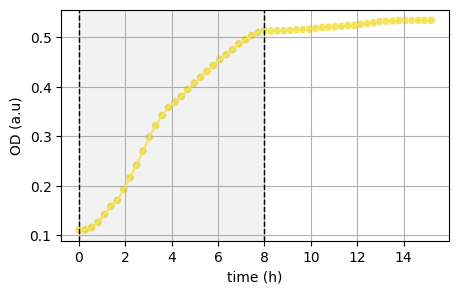

In [6]:
t = 8.0 # @param {type:"number"}
y = 'od' # @param ["od", "growth_rate"]
df_cropped = df.copy()

# Visualize the culture without mercury
f, ax = view(df, y=y, inducer=0)
f.set_size_inches(5, 3)
ax = f.gca()

# Add vertical dashed lines
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.axvline(x=t, color='black', linestyle='--', linewidth=1)

# Highlight the area between x=0 and x=N
ax.axvspan(0, t, color='gray', alpha=0.1)

# Cropping visually
df_cropped = df_cropped[df_cropped['time'] <= t]

# Visualization
plt.show()

### Step N°3: find the best linear region per culture

First, we create a dataframe to store the time intervals corresponding to the *best linear region* per culture. For the mercury biosensor, we search for the highest available $R^2$ with a minimum of 12 data points, corresponding to approximately 3 hours of measurements.

In [7]:
initial_lsmatrix = pd.DataFrame({
    'inducer': df_cropped['inducer'].unique(),
    'minimum': np.nan,
    'maximum': df_cropped['time'].max(),
    'slope': np.nan,
    'intercept': np.nan,
    'R2': np.nan
})

In [8]:
# Displaying the mercury concentrations used during titration
[i for i in df_cropped['inducer'].unique()]

[0.0, 1.0, 2.0, 5.0, 10.0, 25.0, 50.0, 125.0, 250.0, 500.0, 1000.0, 2000.0]

Then, we can iteratively remove the earliest time points per mercury concentration until we maximize each $R^2$. Here, the time points that are earlier than the value prompted in `early_point` are going to be ignored. If the highest $R^2$ is reached, click on `save` and re-run the code to update the results.

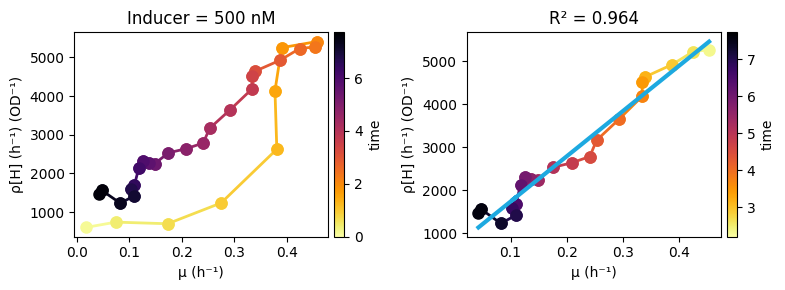

In [23]:

inducer = 500  # @param {type:"number"}
early_point = 2  # @param {type:"number"}
save = False  # @param {type:"boolean"}

# Plot the linear view and get the figure, slope, and R2
f, slope, intercept, r_squared = linear_view(df_cropped, early_point, inducer=inducer)
plt.show()

# Update the 'minimum', 'slope', and 'R2' values in 'initial_lsmatrix' if save is True
if save:
    # Update the minimum value, slope, and R2 for the specific inducer
    initial_lsmatrix.loc[initial_lsmatrix['inducer'] == inducer, 'minimum'] = early_point
    initial_lsmatrix.loc[initial_lsmatrix['inducer'] == inducer, 'slope'] = slope
    initial_lsmatrix.loc[initial_lsmatrix['inducer'] == inducer, 'R2'] = r_squared
    initial_lsmatrix.loc[initial_lsmatrix['inducer'] == inducer, 'intercept'] = intercept

    print(f"The linear section for inducer {inducer:.1f} was saved successfully.")
    print(initial_lsmatrix)

### Step N°4: identify the consistent time interval

In [24]:
# We evaluate the matrix with the best linear regions
initial_lsmatrix

,inducer,minimum,maximum,slope,intercept,R2
0,0.0,3.5,7.7325,26.350137,-0.456315,0.194265
1,1.0,3.5,7.7325,61.717382,0.094567,0.131812
2,2.0,3.5,7.7325,151.055616,-7.288870,0.611422
3,5.0,2.0,7.7325,202.816437,-0.894751,0.747947
4,10.0,2.0,7.7325,497.986597,0.533448,0.914613
5,25.0,1.5,7.7325,1170.427702,17.188238,0.929748
6,50.0,1.5,7.7325,2009.613490,90.345490,0.934914
7,125.0,1.5,7.7325,3492.133625,167.912785,0.946979
8,250.0,1.5,7.7325,6003.389666,479.285802,0.954586
9,500.0,2.0,7.7325,10542.030203,686.444617,0.963737


Finally, we determine a value for the earliest time point (`early_point`) that is consistent across cultures. We fit a Hill equation ($f_h = H \frac{I_i}{I_i + k_i}$), knowing beforehand that the cooperativity of the mercury biosensor is $n = 1$.

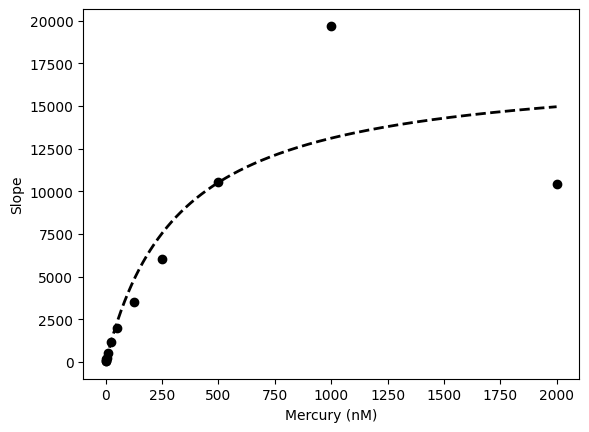

In [26]:
early_point = 3 # @param {type:"number"}

best_lsmatrix = initial_lsmatrix

best_lsmatrix['minimum'] = early_point

from scipy.optimize import curve_fit

# Define the nonlinear model function without 'n'
def nonlinear_model(x, H, ki):
    return H * (x) / (x + ki)

# Initial conditions
initial_params = [6000, 300]  # H = 6000, ki = 300

# Fit the model to the data using curve_fit
params, covariance = curve_fit(nonlinear_model, best_lsmatrix['inducer'], best_lsmatrix['slope'], p0=initial_params)

# Calculate standard deviations of the parameters (square root of diagonal of covariance matrix)
std_devs = np.sqrt(np.diag(covariance))

# Store coefficients and standard deviations in a DataFrame
coefficients_df = pd.DataFrame({
    'Parameter': ['H', 'ki'],
    'Estimate': params,
    'Std Dev': std_devs
})

# Plot the scatter points
plt.scatter(best_lsmatrix['inducer'], best_lsmatrix['slope'], color='black')

# Generate fitted curve
inducer_range = np.linspace(min(best_lsmatrix['inducer']), max(best_lsmatrix['inducer']), 500)
fitted_curve = nonlinear_model(inducer_range, *params)

# Plot the fitted curve with black dashed lines
plt.plot(inducer_range, fitted_curve, color='black', linestyle='--', linewidth=2)

# Labels and title
plt.xlabel('Mercury (nM)')
plt.ylabel('Slope')

# Show the plot (no legend)
plt.show()

Evaluating the Hill coefficients.

In [27]:
coefficients_df

,Parameter,Estimate,Std Dev
0,H,17399.855795,3645.242990
1,ki,327.165965,202.160202


Finally, we can observe the plot of growth rate ($\mu$) and production rate ($\rho_h$) with the newly defined time interval.

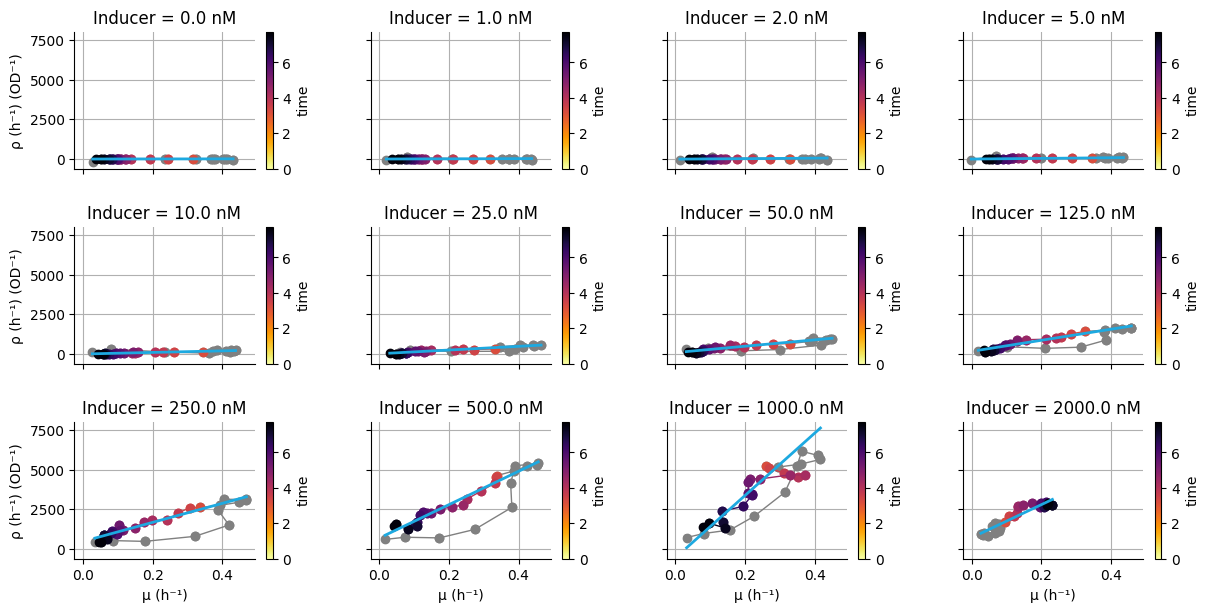

In [30]:
f = rates_plot(df_cropped, lsmatrix = best_lsmatrix, slope = True)
plt.show()